In [115]:
%matplotlib inline
import numpy as np
import random
import itertools
import os
import glob
import math
import time

import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('ytick', labelsize=25)
rc('xtick', labelsize=25)

from ipywidgets import interact
import ipywidgets as widgets

In [3]:
def dist(v1, v2):
    
    return np.sqrt((v2[0] - v1[0])**2 + (v2[1] - v1[1])**2)


def initializePositions(L, N, s):
    """
    Generate a N particles with radius s 
    in box size L that do not overlap
    """
    
    x0, y0 = [], []
    x0.append(np.random.uniform(s,L-s))
    y0.append(np.random.uniform(s,L-s))

    for i in range(1,N):

        K = len(x0)
        collision = [True for i in range(K)]

        while True in collision:
            xi_prop = np.random.uniform(s,L-s)
            yi_prop = np.random.uniform(s,L-s)

            for k in range(K):

                d = dist((x0[k], y0[k]), (xi_prop, yi_prop))
                if d < 2*s:
                    collision[k] = True
                else:
                    collision[k] = False

        x0.append(xi_prop)
        y0.append(yi_prop)
        
    return np.array(x0), np.array(y0)


def initializeVelocities(N):
    
    # Initialize velocity magnitudes
    v0 = np.random.uniform(0,vtot,N)
    u0 = np.sqrt(np.ones(N)*vtot**2 - v0**2)

    # add sign to component to velocities
    v0 = np.random.choice([-1,1], N) * v0
    u0 = np.random.choice([-1,1], N) * u0
    
    return v0, u0

In [106]:
def runSimulation(x0, y0, v0, u0, T):
    
    pos_x, pos_y = [x0], [y0]
    vel_x, vel_y = [v0], [u0]

    for t in range(T): #iterate over time-step
        
        x_curr, y_curr = pos_x[-1], pos_y[-1]
        v_curr, u_curr = vel_x[-1], vel_y[-1]

        del_x, del_y = np.zeros(N), np.zeros(N)
        del_v, del_u = np.zeros(N), np.zeros(N)

        # ================================
        # Advance particle positions
        # ================================
        for i in range(N): #iterate over each particle
    
            dxi = v_curr[i] * dt
            dyi = u_curr[i] * dt  
            
            xprop_i = x_curr[i] + dxi
            yprop_i = y_curr[i] + dyi     
           
            # ================================
            # Check for particle-wall collisions
            # ================================
            if xprop_i < s:   # left wall
                del_x[i] += s - xprop_i
                del_v[i] -= 2*v_curr[i]

            elif xprop_i > L-s:   # right wall
                del_x[i] += L - x_curr[i] - s
                del_v[i] -= 2*v_curr[i]

            else:
                del_x[i] += dxi

            if yprop_i < s:   # bottom wall
                del_y[i] += s - yprop_i
                del_u[i] -= 2*u_curr[i]

            elif yprop_i > L-s:   # top wall
                del_y[i] += L - y_curr[i] - s
                del_u[i] -= 2*u_curr[i]

            else:
                del_y[i] += dyi
                
        x_new = x_curr + del_x
        y_new = y_curr + del_y
            
        # ================================
        # Check for particle-particle collisions
        # ================================
        
        # Iterate over all (N choose 2) combinations of particle pairs
        perm = list(itertools.combinations(range(N), 2))
        
        for p in perm:
            
            i, j = p
            separation = np.sqrt((x_new[i] - x_new[j])**2 + (y_new[i] - y_new[j])**2)
            
            if separation < 2*s:
                
                # particles exchange velocities
                del_v[i] += v_curr[j] - v_curr[i]
                del_v[j] += v_curr[i] - v_curr[j]
                
                del_u[i] += u_curr[j] - u_curr[i]
                del_u[j] += u_curr[i] - u_curr[j]
                
                # x,y component distances between particles
                dx = abs(x_new[i] - x_new[j])
                dy = abs(y_new[i] - y_new[j])
                
                vm_tot = abs(v_curr[i]) + abs(v_curr[j])
                um_tot = abs(u_curr[i]) + abs(u_curr[j])
            
                theta = math.atan(dy/dx)
                dx_i = v_curr[j]/vm_tot * (2*s*math.cos(theta) - dx)
                dy_i = u_curr[j]/um_tot * (2*s*math.sin(theta) - dy)
                
                dx_j = v_curr[i]/vm_tot * (2*s*math.cos(theta) - dx)
                dy_j = u_curr[i]/um_tot * (2*s*math.sin(theta) - dy)

                del_x[i] += dx_i
                del_y[i] += dy_i
                
                del_x[j] += dx_j
                del_y[j] += dx_j
        
        pos_x.append(x_curr + del_x)
        pos_y.append(y_curr + del_y) 

        vel_x.append(v_curr + del_v)
        vel_y.append(u_curr + del_u)  
        
    return np.array(pos_x), np.array(pos_y)

In [6]:
def plotParticles(x, y, **kwargs):    

    fig, ax = plt.subplots(figsize=[10,10])
    
    for i in range(N):
        circle = plt.Circle((x[i], y[i]), radius=s, color='r')
        ax.add_artist(circle)

    plt.xlim(0,L)
    plt.ylim(0,L)
    if 't' in kwargs:
        plt.title(r"$T=%s$"%(kwargs.get('t')), fontsize=30)
    plt.minorticks_on()
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.close()
    
    return fig

## Run Simulation

In [113]:
E = 10    # energy
N = 100    # number of particles
s = 2    # particle radius
L = 100   # box length
T = 5000   # number of time steps
dt = .001   # time step

vtot = np.sqrt(2*E)

x0, y0 = initializePositions(L, N, s)
v0, u0 = initializeVelocities(N)

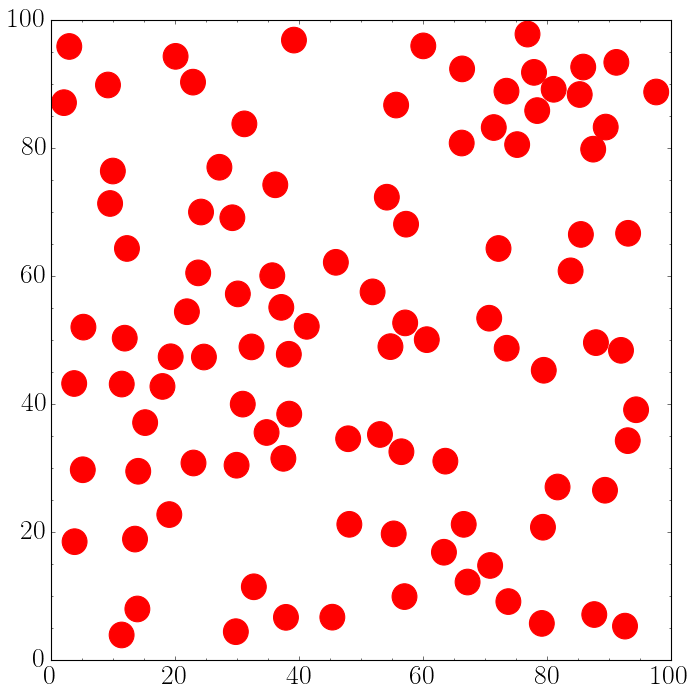

In [114]:
plotParticles(x0, y0)

In [116]:
t0 = time.time()
pos_x, pos_y = runSimulation(x0, y0, v0, u0, T)
print(time.time() - t0)

96.88455176353455


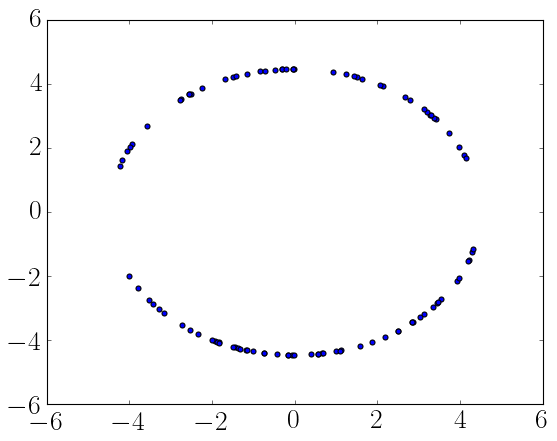

In [117]:
plt.scatter(v0, u0)
plt.show()

### Plot and Animate

KeyboardInterrupt: 

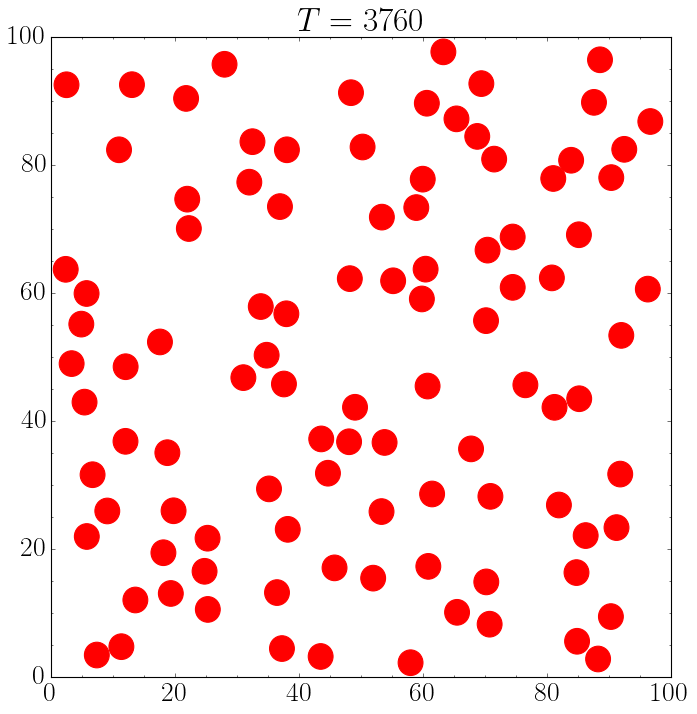

In [120]:
for f in glob.glob('plots/*'):
    os.system(f'rm {f}')
    
tvals = np.arange(0,T,20)
print(f'Plotting {len(tvals)} plots...')
for t in tvals:  
    pl = plotParticles(pos_x[t], pos_y[t], t=t, save=f'plots/t{t}.png')

In [146]:
ordered_plots = ' '.join([f'plots/t{i}.png' for i in tvals])
os.system(f'convert -delay 0 -loop 10 {ordered_plots} animation.gif')

0

In [326]:
def plot_interact(t=0):    
    
    return plotParticles(pos_x[t], pos_y[t])

interactive_plot = interactive(plot_interact, t=(0,T,1))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(IntSlider(value=0, description='t', max=30), Output(layout=Layout(height='700px'))), _do…